# 11 Non-Compliance and Instruments


In [1]:
from toolz.curried import *

import pandas as pd
import numpy as np
from scipy.special import expit

import statsmodels.formula.api as smf

import seaborn as sns
from matplotlib import pyplot as plt


from cycler import cycler

color=['0.0', '0.4', '0.8']
default_cycler = (cycler(color=color))
linestyle=['-', '--', ':', '-.']
marker=['o', 'v', 'd', 'p']

plt.rc('axes', prop_cycle=default_cycler)

## Non-Compliance


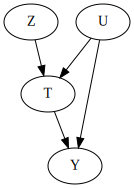

In [2]:
from graphviz import Digraph

gr = Digraph()

gr.edge("U", "T")
gr.edge("U", "Y")
gr.edge("Z", "T")
gr.edge("T", "Y")

gr

In [3]:
import pandas as pd
import numpy as np

df = pd.read_csv("./data/prime_card.csv")

df.head()

,age,income,credit_score,prime_elegible,prime_card,pv,tau,categ
0,37.7,9687.0,822.0,0,0,4913.79,700.0,complier
1,46.0,13731.0,190.0,0,0,5637.66,200.0,never-taker
2,43.1,2839.0,214.0,1,1,2410.45,700.0,complier
3,36.0,1206.0,318.0,1,1,1363.06,700.0,complier
4,39.7,4095.0,430.0,0,0,2189.80,700.0,complier


## Extending Potential Outcomes


In [4]:
m = smf.ols("pv~prime_elegible", data=df).fit()
m.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,2498.3618,24.327,102.701,0.000,2450.677,2546.047
prime_elegible,321.3880,34.321,9.364,0.000,254.113,388.663


In [5]:
df["tau"].mean()

413.45

In [6]:
m = smf.ols("pv~prime_card", data=df).fit()
m.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,2534.4947,19.239,131.740,0.000,2496.783,2572.206
prime_card,588.1388,41.676,14.112,0.000,506.446,669.831


## Instrument Identification Assumptions


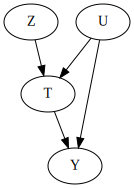

In [7]:
from graphviz import Digraph

gr = Digraph()

gr.edge("U", "T")
gr.edge("U", "Y")
gr.edge("Z", "T")
gr.edge("T", "Y")

gr

## First Stage


In [8]:
first_stage = smf.ols("prime_card ~ prime_elegible", data=df).fit()
first_stage.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,6.729e-15,0.005,1.35e-12,1.000,-0.010,0.010
prime_elegible,0.4242,0.007,60.536,0.000,0.410,0.438


In [9]:
df.groupby("categ").size()/len(df)

categ
complier       0.4269
never-taker    0.5731
dtype: float64

## Reduced Form


In [10]:
red_form = smf.ols("pv ~ prime_elegible", data=df).fit()
red_form.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,2498.3618,24.327,102.701,0.000,2450.677,2546.047
prime_elegible,321.3880,34.321,9.364,0.000,254.113,388.663


In [11]:
late = red_form.params["prime_elegible"] / first_stage.params["prime_elegible"]
late

757.6973795343938

In [12]:
df.groupby("categ")["tau"].mean()

categ
complier       700.0
never-taker    200.0
Name: tau, dtype: float64

## Two Stage Least Squares


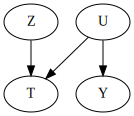

In [13]:
gr = Digraph()

gr.edge("U", "T")
gr.edge("U", "Y")
gr.edge("Z", "T")
gr

In [14]:
iv_regr = smf.ols("pv ~ prime_card",
                  data=df.assign(prime_card=first_stage.fittedvalues)).fit()

iv_regr.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,2498.3618,24.327,102.701,0.000,2450.677,2546.047
prime_card,757.6974,80.914,9.364,0.000,599.091,916.304


### Standard Error


In [15]:
Z = df["prime_elegible"]
T = df["prime_card"]
n = len(df)

# not the same as iv_regr.resid!
e_iv = df["pv"] - iv_regr.predict(df)
compliance = np.cov(T, Z)[0, 1]/Z.var()

se = np.std(e_iv)/(compliance*np.std(Z)*np.sqrt(n))

print("SE IV:", se)
print("95% CI:", [late - 2*se, late + 2*se])

SE IV: 80.52861026141942
95% CI: [596.6401590115549, 918.7546000572327]


In [16]:
from linearmodels import IV2SLS

formula = 'pv ~ 1 + [prime_card ~ prime_elegible]'
iv_model = IV2SLS.from_formula(formula, df).fit(cov_type="unadjusted")

iv_model.summary.tables[1]

,Parameter,Std. Err.,T-stat,P-value,Lower CI,Upper CI
Intercept,2498.4,24.211,103.19,0.0000,2450.9,2545.8
prime_card,757.70,80.529,9.4090,0.0000,599.86,915.53


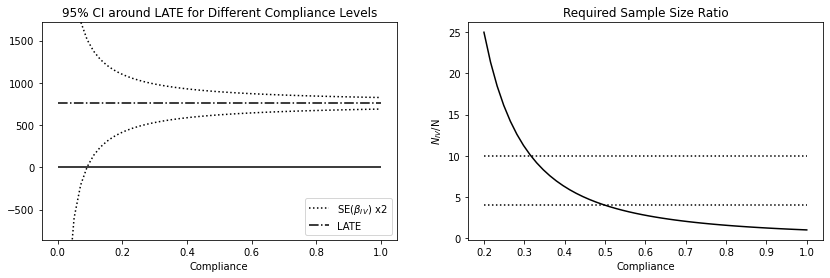

In [17]:
se_formula_iv = lambda compliance: np.std(e_iv)/(compliance*np.std(Z)*np.sqrt(n))
x = np.linspace(0.01, 1, 50)

effect = iv_regr.params["prime_card"]


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))

ax1.plot(x, effect-se_formula_iv(x)*2, label="SE($\\beta_{IV}$) x2", ls=":", color="0")
ax1.plot(x, effect+se_formula_iv(x)*2, ls=":", color="0")
ax1.hlines(effect, 0, 1, ls="-.", label="LATE")
ax1.hlines(0, 0, 1)
ax1.set_xlabel("Compliance")
ax1.set_ylim(-(effect+100), (effect+100)*2)
ax1.legend(loc="lower right")
ax1.set_title("95% CI around LATE for Different Compliance Levels");


x = np.linspace(0.2, 1, 50)
ax2.plot(x, 1/(x**2))
ax2.hlines(10, 0.2, 1, ls=":")
ax2.hlines(4, 0.2, 1, ls=":")
ax2.set_xlabel("Compliance")
ax2.set_ylabel("$N_{IV}$/N")
ax2.set_title("Required Sample Size Ratio");

## Additional Controls and Instruments


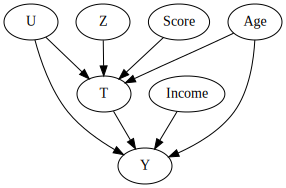

In [18]:
gr = Digraph()

gr.edge("U", "T")
gr.edge("U", "Y")
gr.edge("Z", "T")
gr.edge("T", "Y")
gr.edge("Income", "Y")
gr.edge("Age", "T")
gr.edge("Age", "Y")
gr.edge("Score", "T")

gr

In [19]:
formula = 'pv ~ 1 + [prime_card ~ prime_elegible + credit_score]'
iv_model = IV2SLS.from_formula(formula, df).fit()

iv_model.summary.tables[1]

,Parameter,Std. Err.,T-stat,P-value,Lower CI,Upper CI
Intercept,2519.4,21.168,119.02,0.0000,2477.9,2560.9
prime_card,659.04,58.089,11.345,0.0000,545.19,772.90


In [20]:
formula = 'pv ~ 1 + [prime_card ~ prime_elegible + credit_score] + income + age'
iv_model = IV2SLS.from_formula(formula, df).fit(cov_type="unadjusted")

iv_model.summary.tables[1]

,Parameter,Std. Err.,T-stat,P-value,Lower CI,Upper CI
Intercept,210.62,37.605,5.6008,0.0000,136.91,284.32
age,9.7444,0.8873,10.982,0.0000,8.0053,11.483
income,0.3998,0.0008,471.04,0.0000,0.3981,0.4014
prime_card,693.12,12.165,56.978,0.0000,669.28,716.96



### 2SLS by Hand


In [21]:
formula_1st = "prime_card ~ prime_elegible + credit_score + income + age"
first_stage = smf.ols(formula_1st, data=df).fit()

iv_model = smf.ols("pv ~ prime_card + income + age",
                   data=df.assign(prime_card=first_stage.fittedvalues)).fit()

iv_model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,210.6177,40.832,5.158,0.000,130.578,290.657
prime_card,693.1207,13.209,52.474,0.000,667.229,719.013
income,0.3998,0.001,433.806,0.000,0.398,0.402
age,9.7444,0.963,10.114,0.000,7.856,11.633


### Matrix Implementation


In [22]:
Z = df[["prime_elegible", "credit_score", "income", "age"]].values
X = df[["prime_card", "income", "age"]].values
Y = df[["pv"]].values

def add_intercept(x):
    return np.concatenate([np.ones((x.shape[0], 1)), x], axis=1)

Z_ = add_intercept(Z)
X_ = add_intercept(X)

# pre-multiplying Z_.dot(...) last is important to avoid
# creating a huge NxN matrix
X_hat = Z_.dot(np.linalg.inv(Z_.T.dot(Z_)).dot(Z_.T).dot(X_))

b_iv = np.linalg.inv(X_hat.T.dot(X_hat)).dot(X_hat.T).dot(Y)
b_iv[1]

array([693.12072518])

In [23]:
e_hat_iv = (Y - X_.dot(b_iv))

var = e_hat_iv.var()*np.diag(np.linalg.inv(X_hat.T.dot(X_hat)))

np.sqrt(var[1])

12.164694395033125

In [24]:
t_tilde = smf.ols("prime_card ~ income + age", data=df).fit().resid

e_hat_iv.std()/(t_tilde.std()*np.sqrt(n*first_stage.rsquared))

12.156252763192523

## Key Ideas


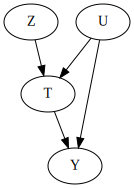

In [25]:
gr = Digraph()

gr.edge("U", "T")
gr.edge("U", "Y")
gr.edge("Z", "T")
gr.edge("T", "Y")

gr

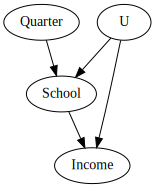

In [26]:
gr = Digraph()

gr.edge("U", "School")
gr.edge("U", "Income")
gr.edge("Quarter", "School")
gr.edge("School", "Income")

gr